In [1]:
import sys
sys.path.append("/home/johnny/wilds/examples")
import wilds
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper

In [2]:
import json
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import entropy
from torchvision import datasets, transforms

In [3]:
full_dataset = wilds.get_dataset(
        dataset='camelyon17',
        root_dir='../../data',
        download=False)

In [4]:
train_dataset = full_dataset.get_subset('train')
test_dataset = full_dataset.get_subset('test')

In [67]:
len(train_dataset)

302436

In [7]:
glob('./*.jsonl')

['./camelyon17_rs_0.jsonl', './camelyon17_us_0.jsonl']

In [52]:
trials_rs = []
for trial in glob('./camelyon17_rs_*.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_rs.append(rounds)
    
trials_us = []
for trial in glob('./camelyon17_us_*.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_us.append(rounds)

In [17]:
rounds[0]['evals'].keys()

dict_keys(['acc_avg', 'acc_slide:0', 'count_slide:0', 'acc_slide:1', 'count_slide:1', 'acc_slide:2', 'count_slide:2', 'acc_slide:3', 'count_slide:3', 'acc_slide:4', 'count_slide:4', 'acc_slide:5', 'count_slide:5', 'acc_slide:6', 'count_slide:6', 'acc_slide:7', 'count_slide:7', 'acc_slide:8', 'count_slide:8', 'acc_slide:9', 'count_slide:9', 'acc_slide:10', 'count_slide:10', 'acc_slide:11', 'count_slide:11', 'acc_slide:12', 'count_slide:12', 'acc_slide:13', 'count_slide:13', 'acc_slide:14', 'count_slide:14', 'acc_slide:15', 'count_slide:15', 'acc_slide:16', 'count_slide:16', 'acc_slide:17', 'count_slide:17', 'acc_slide:18', 'count_slide:18', 'acc_slide:19', 'count_slide:19', 'acc_slide:20', 'count_slide:20', 'acc_slide:21', 'count_slide:21', 'acc_slide:22', 'count_slide:22', 'acc_slide:23', 'count_slide:23', 'acc_slide:24', 'count_slide:24', 'acc_slide:25', 'count_slide:25', 'acc_slide:26', 'count_slide:26', 'acc_slide:27', 'count_slide:27', 'acc_slide:28', 'count_slide:28', 'acc_slide:2

<AxesSubplot:>

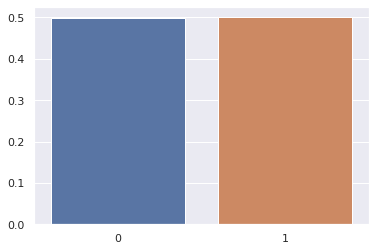

In [21]:
series = pd.Series(train_dataset.y_array).value_counts(normalize=True)
sns.barplot(x=series.index, y=[i for i in series])

<AxesSubplot:>

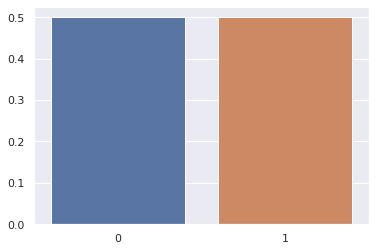

In [22]:
series = pd.Series(test_dataset.y_array).value_counts(normalize=True)
sns.barplot(x=series.index, y=[i for i in series])

### Average accuracy

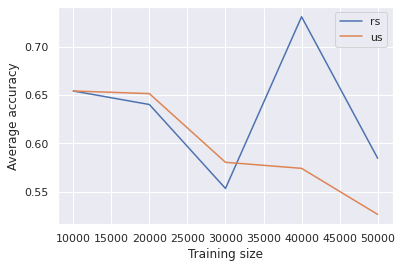

In [18]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = train_dataset.y_array[train_idx]
            x.append(len(train_idx))

            y.append(round['evals']['acc_avg'])

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Average accuracy' : y})
    sns.lineplot(data=df, x='Training size', y='Average accuracy', label=samp)

### Label balance

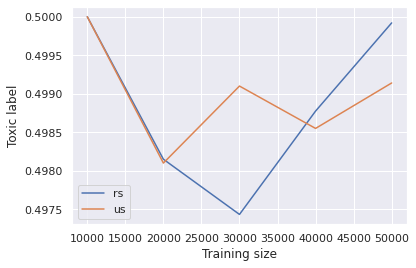

In [23]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = train_dataset.y_array[train_idx]
            x.append(len(train_idx))

            counts = pd.Series(train_labels).value_counts()
            y.append(counts.min() / counts.sum())

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Toxic label' : y})
    sns.lineplot(data=df, x='Training size', y='Toxic label', label=samp)

### Calibration

Automatically created module for IPython interactive environment


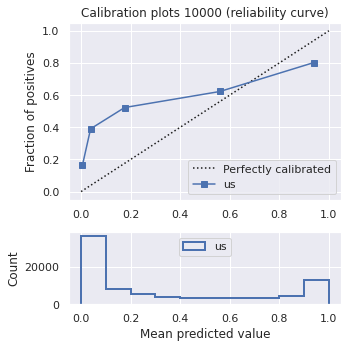

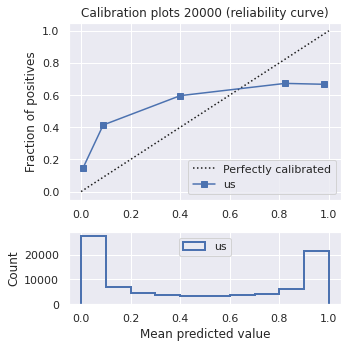

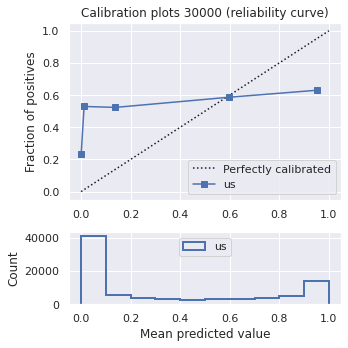

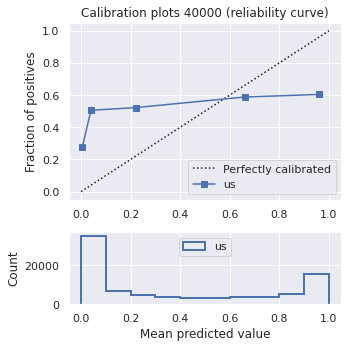

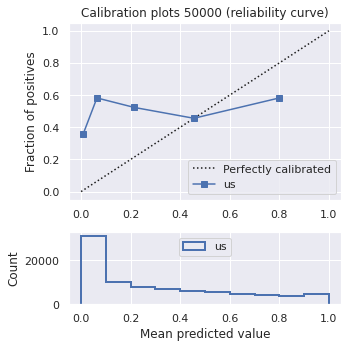

In [73]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from scipy.special import softmax

# #############################################################################
# Plot calibration plots

x, y = [], []
for rounds in trials_us:
    for round in rounds:
        plt.figure(figsize=(5, 5))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        
        probs = softmax(np.array(round['test_preds']), axis=1)
        labels = test_dataset.y_array
        train_idx = round['train_idx']
        prob_pos = probs[:, 1]
        y_test = labels
        
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=5, strategy='quantile')

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (samp, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label='us',
                 histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration plots %d (reliability curve)' % len(train_idx))

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()
        plt.show()

In [66]:
from sklearn.metrics import confusion_matrix
